# Correlation matrices visualization of CIFAR-100 models

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=100):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, _ = model(data)
            preds = outputs
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    for p, l in zip(all_preds, all_labels):
        cnt[l, 0] += 1
        matrix[l] += p
    matrix /= cnt
    return matrix

def get_tea_stu_diff(tea, stu, mpath, max_diff):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    print("load model successfully!")
    ms = get_output_metric(model, val_loader)
    mt = get_output_metric(tea_model, val_loader)
    diff = np.abs((ms - mt)) / max_diff
    for i in range(100):
        diff[i, i] = 0
    print('max(diff):', diff.max())
    print('mean(diff):', diff.mean())
    seaborn.heatmap(diff, vmin=0, vmax=1.0, cmap="PuBuGn")
    plt.show()

In [3]:
# set a common max-value of the difference for fair comparsion between different methods
MAX_DIFF = 3.0

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:27,  5.78it/s]
157it [02:13,  1.18it/s]


max(diff): 0.8985582387199003
mean(diff): 0.09006057001758816


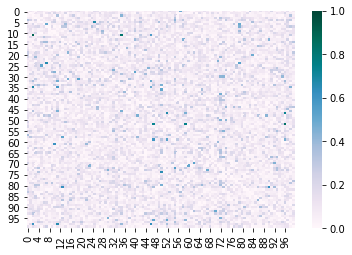

In [4]:
# KD baseline
mpath = "../../download_ckpts/kd_resnet8x4"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:28,  5.44it/s]
157it [04:52,  1.86s/it]


max(diff): 0.41605710864067075
mean(diff): 0.04375380312281896


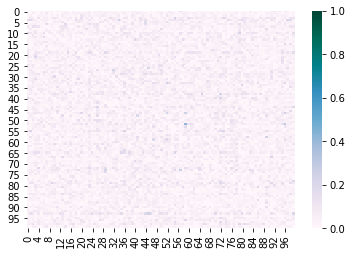

In [5]:
# Our DKD
mpath = "../../download_ckpts/dkd_resnet8x4"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

# Correlation matrices visualization of CUB-200 models

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn

from mdistiller.models import cub_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg
from train_origin import modify_student_model_for_cub200, modify_teacher_model_for_cub200

In [11]:
# visualize the difference between the teacher's output logits and the student's
def get_output_metric(model, val_loader, num_classes=200):
    model.eval()
    device = next(model.parameters()).device 
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            data = data.to(device)
            labels = labels.to(device)
            outputs, _ = model(data)
            preds = outputs.to(device)
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    for p, l in zip(all_preds, all_labels):
        cnt[l, 0] += 1
        matrix[l] += p
    matrix /= cnt
    return matrix

def get_tea_stu_diff(tea, stu, mpath, tea_path, max_diff, name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu + '_sdd'
    cfg.DISTILLER.TEACHER = tea + '_sdd'
    cfg.DATASET.TYPE = 'cub200'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cub_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model = modify_student_model_for_cub200(model, cfg, n_cls=num_classes)
    model = model.to(device)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cub_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model = modify_teacher_model_for_cub200(tea_model, cfg, n_cls=num_classes)
    tea_model = tea_model.to(device)
    checkpoint = torch.load(tea_path, map_location='cpu', weights_only=False)
    tea_model.load_state_dict(checkpoint["model"])
    print("load model successfully!")
    ms = get_output_metric(model, val_loader)
    mt = get_output_metric(tea_model, val_loader)
    diff = np.abs((ms - mt)) / max_diff
    for i in range(200):
        diff[i, i] = 0
    print('max(diff):', diff.max())
    print('mean(diff):', diff.mean())
    seaborn.heatmap(diff, vmin=0, vmax=1.0, cmap="PuBuGn")
    plt.savefig(name + ".png", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

In [9]:
# set a common max-value of the difference for fair comparsion between different methods
MAX_DIFF = 3.0

[1, 2, 4]
[1, 2, 4]
load model successfully!


182it [00:26,  6.90it/s]
182it [00:27,  6.72it/s]


max(diff): 0.5217578640018683
mean(diff): 0.08292718039600132


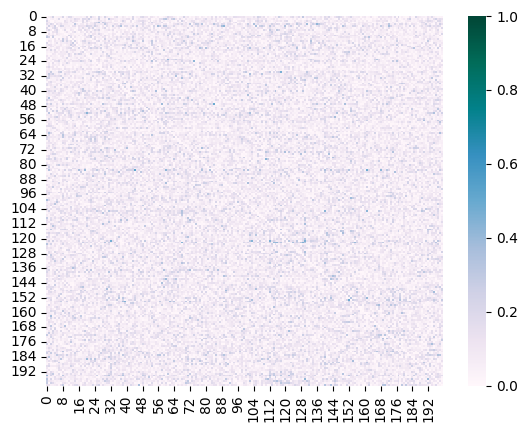

In [16]:
# KD baseline
mpath = "./output/cub200_baselines_gamma2/KD,res32x4_sdd,shuv1_sdd/student_best"
tea_path = "../Checkpoints/save/cub200/resnet32x4_vanilla/resnet32x4_best.pth"
get_tea_stu_diff("resnet32x4", "ShuffleV1", mpath, tea_path, MAX_DIFF, "KD_map")

[1, 2, 4]
[1, 2, 4]
load model successfully!


182it [00:26,  6.85it/s]
182it [00:26,  6.78it/s]


max(diff): 0.6709450483322144
mean(diff): 0.09918027929557989


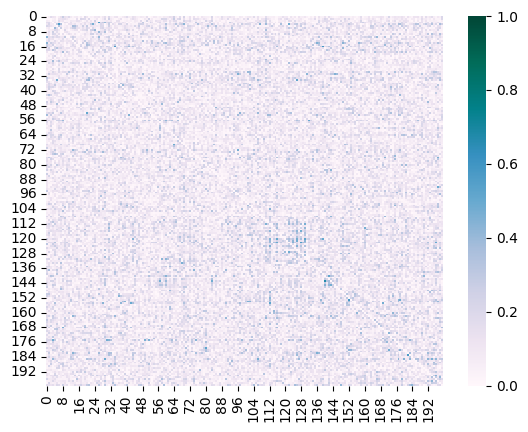

In [15]:
mpath = "./output/cub200_baselines_gamma2/CD_SDD_KD,res32x4_sdd,shuv1_sdd/student_best"
tea_path = "../Checkpoints/save/cub200/resnet32x4_vanilla/resnet32x4_best.pth"
get_tea_stu_diff("resnet32x4", "ShuffleV1", mpath, tea_path, MAX_DIFF, "CD_map")